# PREDICTING DEFAULTING LIKELIHOOD USING LOGISTIC REGRESSION

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
loan = pd.read_csv("loan_data.csv")
loan.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# UNDERSTANDING DATA

In [3]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
print(f"There are {loan.shape[0]} loan applicants")

There are 45000 loan applicants


In [5]:
# change columns data types
columns_category = ["person_gender", 
                    "person_education", 
                    "person_home_ownership", 
                    "loan_intent",
                    "previous_loan_defaults_on_file"]

loan[columns_category] = loan[columns_category].astype("category")
loan["person_age"] = loan["person_age"].astype("int64")
loan["cb_person_cred_hist_length"] = loan["cb_person_cred_hist_length"].astype("int64")
print(loan.dtypes)

person_age                           int64
person_gender                     category
person_education                  category
person_income                      float64
person_emp_exp                       int64
person_home_ownership             category
loan_amnt                          float64
loan_intent                       category
loan_int_rate                      float64
loan_percent_income                float64
cb_person_cred_hist_length           int64
credit_score                         int64
previous_loan_defaults_on_file    category
loan_status                          int64
dtype: object


In [6]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


#### **1. person_age**
- **Issue:** Ages over 100 are statistically rare and may indicate data errors.
- **Suggestion:** Cap or filter the data for **`person_age > 100`**. Additionally:
  - Consider creating a binary feature (e.g., `elderly_flag`) for individuals aged over 80, as they are more likely to default due to health-related issues or mortality.

#### **2. person_income**
- **Issue:** Extremely high incomes, such as **R7,200,766**, could be outliers.
- **Suggestion:** 
  - Investigate the context of this data point. If legitimate, consider capping (e.g., using a 99th percentile threshold) or applying logarithmic transformation to reduce the skewness.
  - Check if this income correlates with other factors like high `person_age` or extraordinary `person_emp_exp`.

#### **3. person_emp_exp**
- **Issue:** Absurd values like 125 years of employment experience are unrealistic.
- **Suggestion:**
  - Set a plausible cap (e.g., **`person_emp_exp ≤ person_age - 18`**). This assumes people start working at 18 years old.
  - Investigate and potentially impute or remove such records.

#### **4. cb_person_cred_hist_length**
- **Issue:** Credit history length values should logically align with the person's age.
- **Suggestion:**
  - Validate this field using **`cb_person_cred_hist_length ≤ person_age - 18`** to ensure logical consistency.
  - If inconsistencies are found, review or cap the values appropriately.


In [7]:
loan.describe(include='category').T

,count,unique,top,freq
person_gender,45000,2,male,24841
person_education,45000,5,Bachelor,13399
person_home_ownership,45000,4,RENT,23443
loan_intent,45000,6,EDUCATION,9153
previous_loan_defaults_on_file,45000,2,Yes,22858


In [8]:
# Check for missing and duplicated values
print(f'\nMissing values: {loan.isna().sum().sum()}')
print(f'Duplicated values: {loan.duplicated().sum()}')


Missing values: 0
Duplicated values: 0


## DATA CLEANING AND PREPROCESSING 

#### Rule based cleaning

In [9]:
# get the column names as we will be cleaning column by column 
loan.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

**Age**

In [10]:
loan1 = loan[loan.person_age.between(18, 99)]
print(loan.shape[0])
print(loan1.shape[0])

45000
44993


**Loan Intent**

In [11]:
loan1.groupby("loan_intent")["loan_amnt"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_intent,,,,,,,,
DEBTCONSOLIDATION,7145.0,9548.333660,6377.318220,500.0,5000.0,8000.0,12400.0,35000.0
EDUCATION,9151.0,9506.598951,6247.574197,700.0,5000.0,8000.0,12000.0,35000.0
HOMEIMPROVEMENT,4783.0,10419.187330,6661.533228,500.0,5000.0,9000.0,15000.0,35000.0
MEDICAL,8548.0,9137.959172,6131.015135,500.0,5000.0,7846.0,12000.0,35000.0
PERSONAL,7551.0,9604.528142,6296.660767,500.0,5000.0,8000.0,12000.0,35000.0
VENTURE,7815.0,9659.385925,6283.028810,563.0,5000.0,8000.0,12800.0,35000.0


**person_emp_exp**

In [12]:
# person_emp_exp ≤ person_age - 18
loan2 = loan1[loan1.person_emp_exp <= loan1.person_age - 18]
print(loan1.shape)
print(loan2.shape)

(44993, 14)
(44993, 14)


**cb_person_cred_hist_length**

In [13]:
# person_emp_exp ≤ person_age - 18
loan2 = loan1[loan1.cb_person_cred_hist_length <= loan1.person_age - 18]
print(loan1.shape)
print(loan2.shape)

(44993, 14)
(44120, 14)


# EDA 

#### UNIVARAITE DISTRIBUTIONS

Distribution of person_gender
Distribution of person_education
Distribution of person_home_ownership
Distribution of loan_intent
Distribution of previous_loan_defaults_on_file


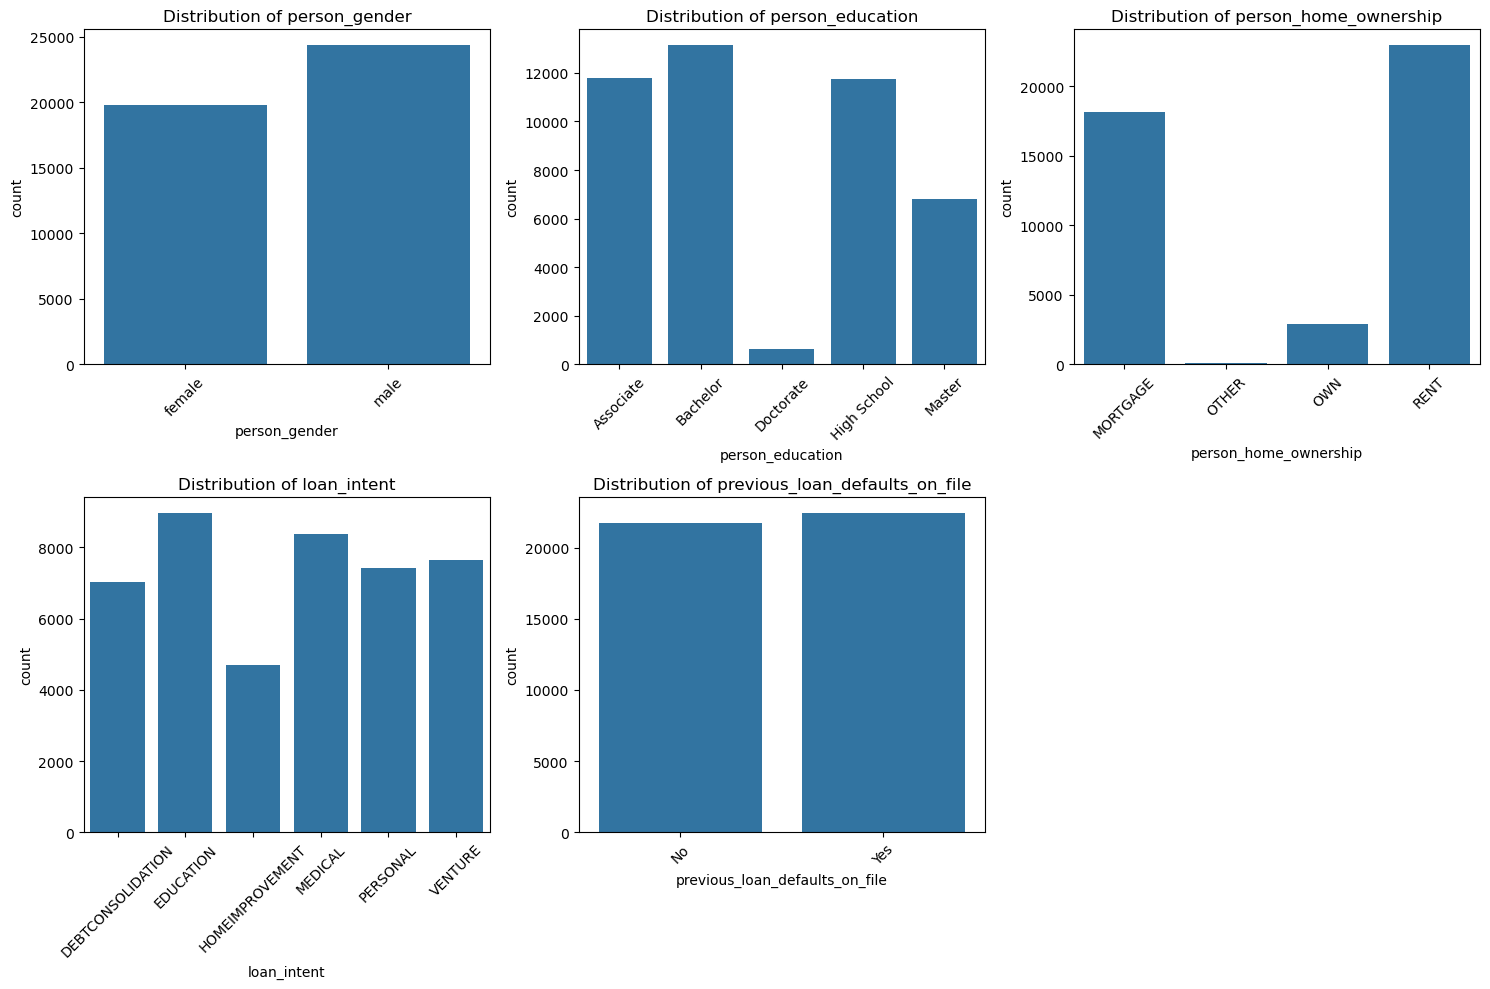

In [14]:
# Number of categorical columns
num_cols = len([col for col in loan2.columns if loan2[col].dtype == "category"])

# Determine the number of rows and columns for the subplot grid
ncols = 3  # Number of columns per row (can adjust based on preference)
nrows = (num_cols // ncols) + (num_cols % ncols > 0)  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten axes array to make iteration easier
axes = axes.flatten()

# Loop over each categorical column
i = 0
for col in loan2.columns:
    if loan2[col].dtype == "category":
        print(f"Distribution of {col}")
        sns.countplot(data=loan2, x=col, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees (you can set it to 90)
        i += 1

# Remove any empty subplots (if num_cols * num_rows > number of categorical columns)
for j in range(i, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

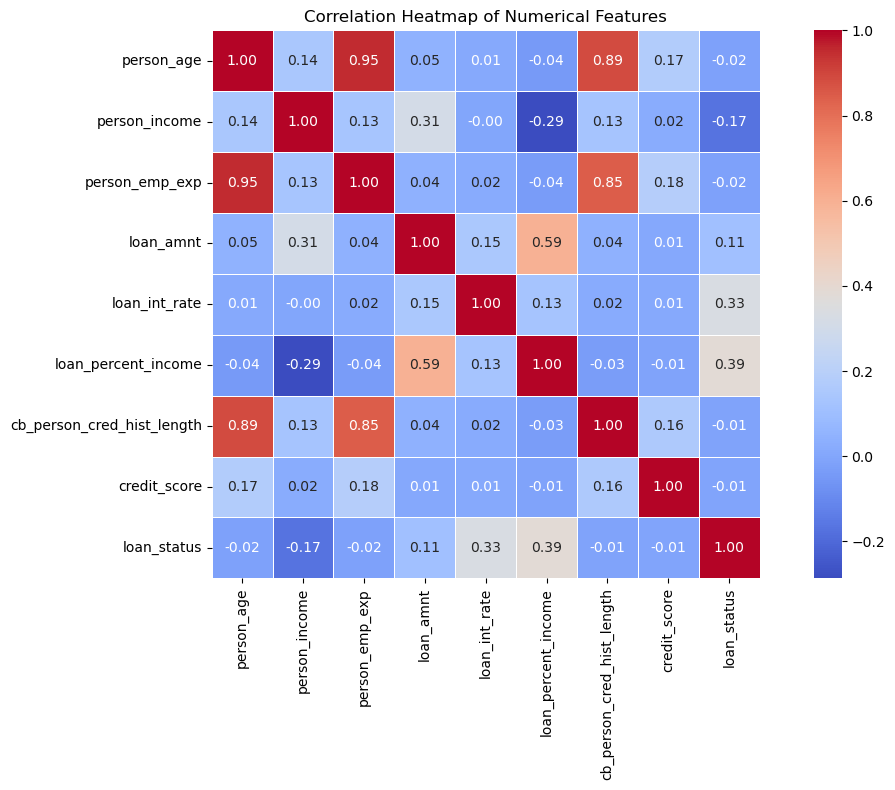

In [15]:
numeric_columns = loan2.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_columns.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, linewidths=0.5)

# Title for the plot
plt.title("Correlation Heatmap of Numerical Features")

# Show the plot
plt.tight_layout()
plt.show()


# FEATURE ENGINEERING 

**Age Based**

In [16]:
loan3 = loan2.copy()

In [17]:
def categorize_age(age):
    if age < 30:
        return 'Young'
    elif 30 <= age < 60:
        return 'Middle-aged'
    else:
        return 'Elderly'

# Function to determine risk level based on loan intent and age group
def assign_risk_level(row):
    age_group = categorize_age(row['person_age'])
    loan_intent = row['loan_intent']
    
    if loan_intent == 'DEBTCONSOLIDATION':
        if age_group == 'Young':
            return 'Medium'
        elif age_group == 'Middle-aged':
            return 'Low'
        else:  # Elderly
            return 'Medium'
    
    elif loan_intent == 'EDUCATION':
        if age_group == 'Young':
            return 'Low'
        elif age_group == 'Middle-aged':
            return 'Medium'
        else:  # Elderly
            return 'High'
    
    elif loan_intent == 'HOMEIMPROVEMENT':
        if age_group == 'Young':
            return 'Low'
        elif age_group == 'Middle-aged':
            return 'Low'
        else:  # Elderly
            return 'Medium'
    
    elif loan_intent == 'MEDICAL':
        if age_group == 'Young':
            return 'Medium'
        elif age_group == 'Middle-aged':
            return 'Medium'
        else:  # Elderly
            return 'High'
    
    elif loan_intent == 'PERSONAL':
        if age_group == 'Young':
            return 'Medium'
        elif age_group == 'Middle-aged':
            return 'Low'
        else:  # Elderly
            return 'Medium'
    
    elif loan_intent == 'VENTURE':
        if age_group == 'Young':
            return 'High'
        elif age_group == 'Middle-aged':
            return 'Medium'
        else:  # Elderly
            return 'High'

    return 'Low'  # Default fallback in case none of the conditions are met

# Apply the function to the loan2 DataFrame and create the new column
loan3['risk_level'] = loan2.apply(assign_risk_level, axis=1)

# Display the updated DataFrame (optional)
print(loan3[['person_age', 'loan_intent', 'risk_level']].head())

   person_age loan_intent risk_level
0          22    PERSONAL     Medium
1          21   EDUCATION        Low
2          25     MEDICAL     Medium
3          23     MEDICAL     Medium
4          24     MEDICAL     Medium


In [18]:
loan3.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,risk_level
0,22,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,No,1,Medium
1,21,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,Yes,0,Low
2,25,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,No,1,Medium
3,23,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,No,1,Medium
4,24,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4,586,No,1,Medium


In [19]:
# Create the financial_strain_risk column based on loan_percent_income >= 0.5
loan3['financial_strain_risk'] = loan3['loan_percent_income'].apply(lambda x: 'High Risk' if x >= 0.5 else 'Low Risk')

In [20]:
loan4 = loan3.drop(columns = "person_gender")

In [21]:
loan4.head()

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,risk_level,financial_strain_risk
0,22,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,No,1,Medium,Low Risk
1,21,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,Yes,0,Low,Low Risk
2,25,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,No,1,Medium,Low Risk
3,23,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,No,1,Medium,Low Risk
4,24,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4,586,No,1,Medium,High Risk


In [22]:
# Create the target variable 'default_likelihood' based on rules
def determine_default_likelihood(row):
    # Initialize risk to 'Low' by default
    risk = 0  # 0 will represent 'Low Risk'
    
    # Apply the rules
    if row['loan_amnt'] > 20000:  # Large loan amount 
        risk += 1
    if row['loan_int_rate'] > 15:  # High interest rate
        risk += 1
    if row['loan_percent_income'] > 0.4:  # High percentage of income
        risk += 1
    if row['credit_score'] < 600:  # Low credit score
        risk += 1
    if row['previous_loan_defaults_on_file'] == 'Yes':  # Previous defaults
        risk += 1
    
    # If risk is above a threshold, classify as 'High Risk' (1), otherwise 'Low Risk' (0)
    return 1 if risk >= 3 else 0

# Apply the function to create the 'default_likelihood' column
loan4['default_likelihood'] = loan4.apply(determine_default_likelihood, axis=1)

In [23]:
loan4.head()

,person_age,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,risk_level,financial_strain_risk,default_likelihood
0,22,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3,561,No,1,Medium,Low Risk,1
1,21,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2,504,Yes,0,Low,Low Risk,0
2,25,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3,635,No,1,Medium,Low Risk,0
3,23,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2,675,No,1,Medium,Low Risk,1
4,24,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4,586,No,1,Medium,High Risk,1


In [24]:
# Calculate the percentage of applicants more likely to default (default_likelihood == 1)
default_percentage = (loan4[loan4['default_likelihood'] == 1].shape[0] / loan4.shape[0]) * 100

# Print the result
print(f"{default_percentage:.2f}% of the applicants are more likely to default")


2.15% of the applicants are more likely to default


In [25]:
# Filter for approved loans (loan_status == 1)
approved_loans = loan4[loan4['loan_status'] == 1]

# Calculate the percentage of applicants more likely to default among approved loans
default_percentage_approved = (approved_loans[approved_loans['default_likelihood'] == 1].shape[0] / approved_loans.shape[0]) * 100

# Print the result
print(f"{default_percentage_approved:.2f}% of the approved loans are more likely to default")


1.50% of the approved loans are more likely to default


In [26]:
loan4['age_group'] = loan4['person_age'].apply(lambda x: 'Young' if x < 30 else ('Middle-aged' if 30 <= x < 60 else 'Elderly'))

## MODELLING

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [28]:
# Convert categorical variables into numerical ones using one-hot encoding
loan5 = pd.get_dummies(loan4, columns=['person_education', 'loan_intent', 'person_home_ownership', 'age_group'], drop_first=True)

# Initialize label encoder and ordinal encoder
le = LabelEncoder()
lo = OrdinalEncoder()

# Label encode the 'previous_loan_defaults_on_file' column (Yes/No to 0/1)
loan5["previous_loan_defaults_on_file"] = le.fit_transform(loan5["previous_loan_defaults_on_file"])

loan5["risk_level"] = lo.fit_transform(loan5[["risk_level"]])  #'Low', 'Medium', 'High'
loan5["financial_strain_risk"] = lo.fit_transform(loan5[["financial_strain_risk"]])  # 'Low Risk', 'High Risk'

# Display the modified columns to check the encoding
loan5[["risk_level", "financial_strain_risk"]].head()

,risk_level,financial_strain_risk
0,2.0,1.0
1,1.0,1.0
2,2.0,1.0
3,2.0,1.0
4,2.0,0.0


In [29]:
loan5.columns

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status',
       'risk_level', 'financial_strain_risk', 'default_likelihood',
       'person_education_Bachelor', 'person_education_Doctorate',
       'person_education_High School', 'person_education_Master',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'age_group_Middle-aged',
       'age_group_Young'],
      dtype='object')

In [30]:
features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 
       'risk_level', 'financial_strain_risk', 'person_education_Bachelor', 'person_education_Doctorate',
       'person_education_High School', 'person_education_Master',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'age_group_Middle-aged',
       'age_group_Young']

In [31]:
# Target variable (default likelihood)
target = 'default_likelihood'

# Scaling the features to standardize them
scaler = StandardScaler()
loan5[features] = scaler.fit_transform(loan5[features])

# Train-test split (80-20 split)
X = loan5[features]
y = loan5[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
selected_features = X_train.columns[fit.support_]

In [33]:
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [34]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {scores}")

Cross-validation accuracy scores: [0.98342776 0.98243377 0.98356708 0.98200878 0.98300042]


In [35]:
# Fit the model on the training data
model.fit(X_train, y_train)

# Now you can use predict_proba to get probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate AUC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")


AUC Score: 0.9839780215950028



Cross-validation accuracy scores: [0.98342776 0.98243377 0.98356708 0.98200878 0.98300042]
Mean Cross-validation Accuracy: 0.9829

AUC Score: 0.9840

Accuracy: 0.9832
Precision: 0.6792
Recall: 0.3871
F1-Score: 0.4932

Confusion Matrix:
[[8604   34]
 [ 114   72]]


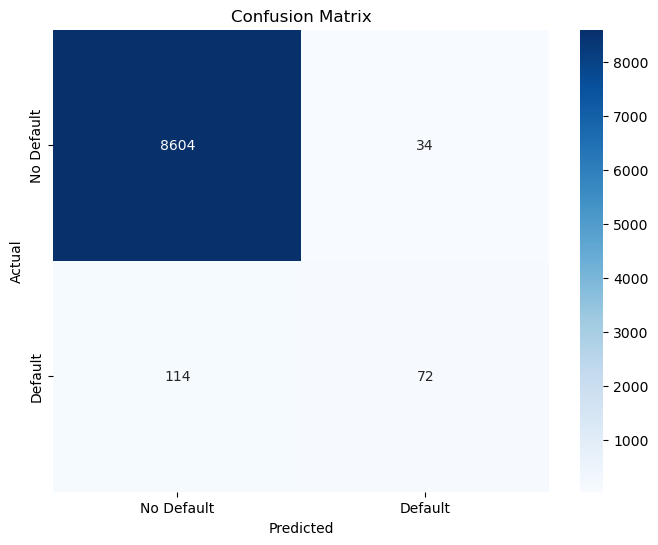

In [36]:
# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores: {scores}")
print(f"Mean Cross-validation Accuracy: {scores.mean():.4f}")

# Fit model
model.fit(X_train, y_train)

# Predict probabilities for the positive class and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")

# Predict the classes and calculate other metrics
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# MODEL MODIFICATION

### Undersampling majority class

In [37]:
minority_class = loan5[loan5['default_likelihood']== 1]
majority_class = loan5[loan5['default_likelihood'] == 0]

print(minority_class.shape[0])
print(majority_class.shape[0])

947
43173


In [38]:
sampled_majority_class = majority_class.sample(minority_class.shape[0])
print(sampled_majority_class.shape[0])

947


In [39]:
df = pd.concat([sampled_majority_class, minority_class])

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-validation accuracy scores: [0.92079208 0.96039604 0.93729373 0.94719472 0.94059406]
AUC Score: 0.9845875139353399

Cross-validation accuracy scores: [0.92079208 0.96039604 0.93729373 0.94719472 0.94059406]
Mean Cross-validation Accuracy: 0.9413

AUC Score: 0.9846

Accuracy: 0.9393
Precision: 0.9305
Recall: 0.9457
F1-Score: 0.9380

Confusion Matrix:
[[182  13]
 [ 10 174]]


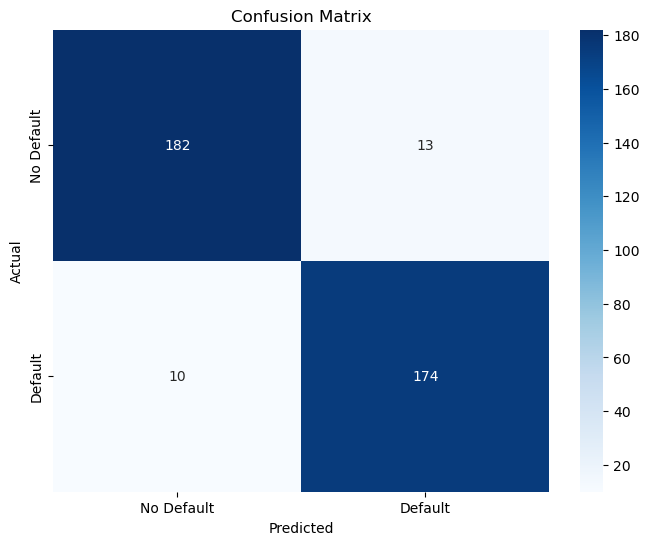

In [40]:
X_sampled = df[features]
y_sampled = df[target]

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
selected_features = X_train.columns[fit.support_]

model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print(grid.best_params_)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {scores}")

# Fit the model on the training data
model.fit(X_train, y_train)

# Now you can use predict_proba to get probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Calculate AUC score
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score}")

# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation accuracy scores: {scores}")
print(f"Mean Cross-validation Accuracy: {scores.mean():.4f}")

# Fit model
model.fit(X_train, y_train)

# Predict probabilities for the positive class and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc_score:.4f}")

# Predict the classes and calculate other metrics
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [41]:
coefficients = model.coef_[0]
the_features = model.feature_names_in_
results = pd.DataFrame({"Features" : the_features, "Coefficients" : coefficients})
results

,Features,Coefficients
0,person_age,0.006129
1,person_income,0.569834
2,person_emp_exp,-0.080936
3,loan_amnt,1.351832
4,loan_int_rate,2.363932
5,loan_percent_income,0.978133
6,cb_person_cred_hist_length,-0.072142
7,credit_score,-1.800195
8,previous_loan_defaults_on_file,2.483759
9,risk_level,-0.154396


In [42]:
import statsmodels.api as sm

# Add a constant for the intercept
X_sampled = sm.add_constant(X_sampled)

# Fit the logistic regression model
logit_model = sm.Logit(y_sampled, X_sampled).fit()

# Print the summary of the model
print(logit_model.summary())


         Current function value: 0.148850
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:     default_likelihood   No. Observations:                 1894
Model:                          Logit   Df Residuals:                     1869
Method:                           MLE   Df Model:                           24
Date:                Sat, 16 Nov 2024   Pseudo R-squ.:                  0.7853
Time:                        20:48:47   Log-Likelihood:                -281.92
converged:                      False   LL-Null:                       -1312.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -6.4467        nan        nan        nan         nan         nan
perso

c:\Users\takue\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
significant = results[results["P-Values"] < 0.05]
print(significant)

KeyError: 'P-Values'